# Partes del notebook:
- Introducción
- Carga de datos.
- Procesamiento de la image. Diferencia de colores usando el modelo LAB.
- Análisis de las componentes conexas.

## Introducción

En este notebook se presenta un prototipo para el análisis oclusal.
La aplicación se divide en carga de datos, procesamiento de la imagen y análisis de la imagen.

## Carga de datos

In [1]:
%matplotlib tk
from tkinter import *
from tkinter.filedialog import askopenfilename
from tkinter.messagebox import showerror

fname = "" # Esto va a ser el nombre del archivo

class MyFrame(Frame):
    def __init__(self):
        Frame.__init__(self)
        self.master.title("Carga Imágenes")
        self.master.rowconfigure(5, weight=1)
        self.master.columnconfigure(5, weight=1)
        self.grid(sticky=W+E+N+S)

        self.button = Button(self, text="Explora", command=self.load_file, width=10)
        self.button.grid(row=1, column=0, sticky=W)

    def load_file(self):
        global fname
        global root
    
        fname = askopenfilename(filetypes=(("Imagenes", "*.jpg"),
                                           ("Imagenes", "*.JPG"),
                                           ("All files", "*.*") ))
        if fname:
            try:
                print(fname)
            except:                     
                showerror("Fallos al cargar el fichero", "Failed to read file\n'%s'" % fname)
            return
        


root = MyFrame()

/home/jose/Dropbox/TFGs/gambas/IMG_1431.JPG


In [1]:
# O más rápido, decir explicitamente la imagen a cargar
fname = "/home/jose/Dropbox/TFGs/gambas/IMG_1431.JPG"

In [2]:
print("Se va a cargar la imagen contenida en ",fname)

Se va a cargar la imagen contenida en  /home/jose/Dropbox/TFGs/gambas/IMG_1431.JPG


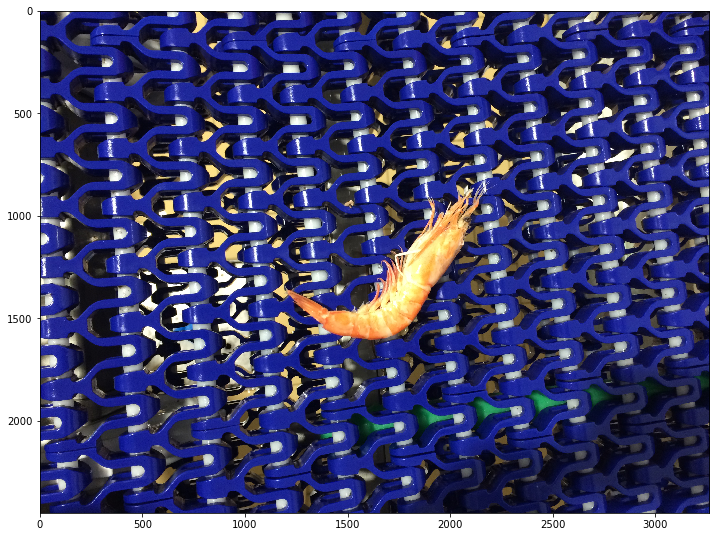

In [3]:
%matplotlib inline

from skimage import io # necesario para leer imágenes
import matplotlib.pyplot as plt #matplotlib es necesario para mostrar gráficos
import matplotlib.cm as cm
import matplotlib.patches as mpatches


# Nota, se podría reducir el tamaño de todas las imágenes para acelerar
imgGrande = io.imread(fname)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(imgGrande, cmap=plt.cm.gray)



## Procesamiento de la imagen


In [4]:

# en skimage se puede pasar de RGB a lab con la función  rgb2lab
from skimage.color import rgb2lab





In [5]:
'''
Función que transforma un número en base 255 en otro en base 1.
'''

def base1(num):
    valorEnBase255 = num
    valorEnBase1 = (valorEnBase255/255)*1
    return valorEnBase1
    
print(base1(255))
print(base1(200))
print(base1(25.5))

1.0
0.7843137254901961
0.1


In [6]:
'''
Función para pasar un pixel de RGB a CIELAB

CIELAB es más apropiado para hacer diferencia de colores
'''
def pixelRGB2LAB(pixel):
    r,g,b = pixel # pixel es una lista con 3 valores, los puedo guardar en 3 variables asi
    rBase1 = base1(r)
    gBase1 = base1(g)
    bBase1 = base1(b)
    
    
    # rgb2lab espera una lista3D, así que le paso el pixel dentro 
    # de una lista de listas y para sacarlo igual.
    return rgb2lab([[[rBase1,gBase1,bBase1]]])[0][0]

In [31]:
'''
Función que recibe 3 parámetros: imagen, color y umbral.
Convierte imagen y color al modelo LAB
Realiza la diferencia de color entre cada uno de los pixels de la imagen y el color pasado como parámetro
Y posteriormente realiza la binarización usando el umbral.
'''

def diferenciaColorLab(imagen,color,umbral):
    print("diferenciaColorLab")
    imagenLab = rgb2lab(imagen)
    colorLab = pixelRGB2LAB(color)
    imagenLab2 = abs(imagenLab-color).mean(axis=2)
    imagenLab3 = imagenLab2 < umbral
    return imagenLab3

diferenciaColorLab


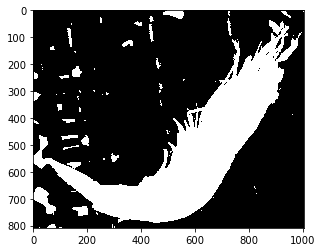

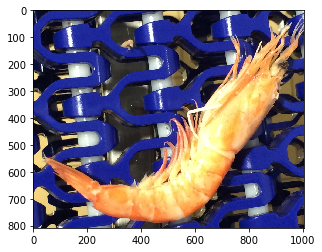

In [33]:
# Ejemplos de uso de las funciones.

# actualiza la ruta


pathPequeImg="/home/jose/Dropbox/TFGs/gambas/peque.jpg"
imgPeque = io.imread(pathPequeImg)
                                        # color RGB de un pixel de dentro de la gamba cogido con gimp
diffCLab = diferenciaColorLab(imgPeque, [ 247,211,114], 160)

plt.imshow(diffCLab,cmap=cm.gray)
plt.figure()
plt.imshow(imgPeque)

## Morfología matemática

http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_morphology.html

Morphological opening on an image is defined as an erosion followed by a dilation. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks.


Morphological closing on an image is defined as a dilation followed by an erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks.



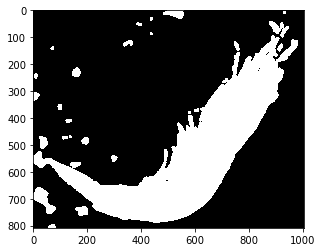

In [60]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

selem = disk(6)



opImg = opening(diffCLab, selem)
plt.imshow(opImg,cmap=cm.gray)


## análisis 
- parte 1: Analisis de componentes conexas

### Análisis parte 1

Mira este enlace con la lista de atributos que se puede sacar de una región
http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

In [17]:
# imports necesarios para hacer el análisis de componentes conexas
from skimage.measure import label
from skimage.measure import regionprops

In [55]:
'''
Función que realiza el análisis de componentes conexas.
Recibe 2 imágenes: la primera de color y la segunda en blanco y negro.
Realizará la búsqueda de componentes conexas sobre la segunda, la primera se usa solo para mostrarla.
Devuelve los anchos y los largos de cada una de las componentes encontradas.
'''

def analiza(img,imgBN):
    
    anchoRegion = []
    largoRegion = []
    
    # crea una figura con dos subfiguras
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 16))
    
    # hace las etiquetas de los ejes invisibles
    ax[0].yaxis.set_visible(False)
    ax[0].xaxis.set_visible(False)
    
    ax[1].yaxis.set_visible(False)
    ax[1].xaxis.set_visible(False)
    
    # en la primera subfigura está la imagen original
    ax[0].imshow(img)
    
    # en la segunda subfigura está la imagen en blanco y negro con las regiones encontradas
    ax[1].imshow(imgBN, cmap=plt.cm.gray)
    
    
    # label es la primera función clave, toma una imagen en blanco y negro
    # y devuelve sus componentes conexas
    label_image = label(imgBN)

    # regionprops es la segunda función clave, toma las componentes conexas
    # y devuelve una lista
    
    
    for region in regionprops(label_image):
        #aqui de una region se puede sacar área y muchas otras cosas 

        # skip small images
        if region.area < 10000:  # esto se debería parametrizar
            continue
            
            
        # draw rectangle around segmented regions
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)
        ax[1].add_patch(rect)
        
        # fijaos que aqui arriba se saca el área, así se pueden sacar todos los demás valores  
        # region es un objeto que describe todas las propiedades de la región
        anchoRegion.append(region.minor_axis_length)
        largoRegion.append(region.major_axis_length)
        
    plt.tight_layout()
    plt.show()

    return anchoRegion,largoRegion
    

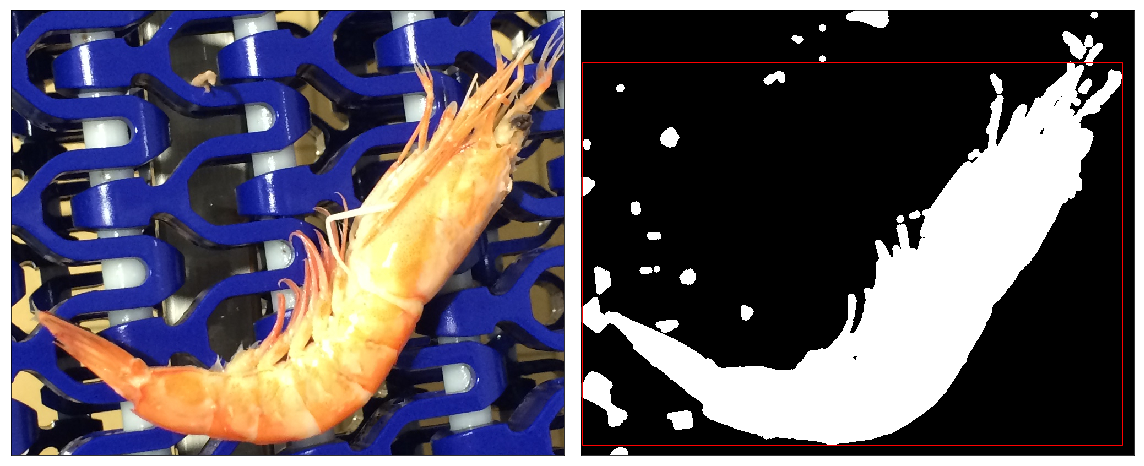

([381.7446251783608], [1033.8221152867138])

In [61]:
analiza(imgPeque,opImg)

# Ejemplo de uso de la función analiza

ancho,largo=
print("Anchos y largos de las regiones analizadas")
print(ancho,largo)

In [44]:
from IPython.display import display
from ipywidgets import widgets, interact, interactive, fixed





cp = widgets.ColorPicker()
cp.value = '#%02x%02x%02x' % (247,211,114)
display(cp)

In [64]:
#Aquí es donde teneis que meter mano.


def ejecuta(img,umbral):
    valorHex= cp.value
    rojoHex = valorHex[1:3]
    verdeHex = valorHex[3:5]
    azulHex = valorHex[5:7]
    
    rojoRGB = int(rojoHex, 16)
    verdeRGB = int(verdeHex, 16)
    azulRGB = int(azulHex, 16)
    
    color = [rojoRGB,verdeRGB,azulRGB]
    

    diff=diferenciaColorLab(img,color,umbral)
    opImg = opening(diff, selem)
    #plt.imshow(diff,cmap=cm.gray,interpolation='none')
    anchos,largos = analiza(opImg,opImg)
    
    
    print("Número de objetos: ",len(anchos))
    
        
    
    
    



In [65]:
interactive(ejecuta,img=fixed(imgGrande),umbral=(140,180))

/home/jose/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:565: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)
